In [1]:

import torch.nn as nn
import torch
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


In [26]:
#Read the data into a pandas data frame 
df = pd.read_parquet("de_train.parquet")


In [3]:
from rdkit import Chem
from rdkit.Chem import rdFMCS

In [4]:
def count_substructure_occurrences(target_smiles, query_smiles):
    try:
        # Convert SMILES to RDKit molecules
        target_mol = Chem.MolFromSmiles(target_smiles)
        query_mol = Chem.MolFromSmiles(query_smiles)

        # Check if the molecules are valid
        if target_mol is None or query_mol is None:
            print("Error: Invalid SMILES.")
            return None

        # Use SubstructMatch to find occurrences
        occurrences = target_mol.GetSubstructMatches(query_mol)

        return len(occurrences)
    except Exception as e:
        print(f"Error: {e}")
        return None

# Example usage
target_smiles = "CCOCC"
query_smiles = "c1ccccc1"
occurrence_count = count_substructure_occurrences(target_smiles, query_smiles)

if occurrence_count is not None:
    print(f"The substructure '{query_smiles}' is found {occurrence_count} times in the molecule '{target_smiles}'.")

The substructure 'c1ccccc1' is found 0 times in the molecule 'CCOCC'.


In [5]:
functional_groups  = ["O", "C=O", "N", "C(=O)N", "C(=O)O", "N=O", "S", "P([O])([O])", "S(=O)([O])([O])", "C=C", "C#C", "c1ccccc1", "F", "Cl", "Br", "I", "C" ]
functional_column_names = [(i, 'int') for i in functional_groups]
SMILES = df["SMILES"].tolist()

functional_groups_block = [[count_substructure_occurrences(i,j) for j in functional_groups ] for i in SMILES]
functional_group_df = pd.DataFrame(functional_groups_block, columns=[name for name, _ in functional_column_names])
functional_group_df = functional_group_df.astype("float64")


In [6]:
#normalizes data between -1 and 1
#returns normalized data and the factors used to normalzie 
def normalize(df):
    min = df.min()
    max=df.max()
    df_normalized = (df - min) / (max-min)
    return df_normalized, min.reset_index(drop=True), max.reset_index(drop=True)


#unnormalize
def unnormalize(normalized_df, min, max):
    return min + normalized_df*(max-min)

In [7]:
############################DATA PREP###############################



####One hot incodes inputs####

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Fit and transform the data
cells = df["cell_type"].values.reshape(-1, 1)
hot_cells = encoder.fit_transform(cells)
cell_mapping = encoder.categories_[0]

compounds = df['sm_name'].values.reshape(-1, 1)
hot_compounds = encoder.fit_transform(compounds)
compound_mapping = encoder.categories_[0]

#Puts together inputs
hot_encoded = np.hstack((hot_cells, hot_compounds))
hot_encoded_df = pd.DataFrame(data = hot_encoded)
inputs_df = pd.concat([hot_encoded_df, functional_group_df], axis=1)

####Normalizes Outputs####

outputs = df.loc[:, 'A1BG':'ZZEF1']
outputs_norm_df, norm_min, norm_max = normalize(outputs)


####Puts Inputs and Outputs Together####
prepped_df = pd.concat([inputs_df, outputs_norm_df], axis=1)

print(inputs_df.dtypes[0])
print(inputs_df.dtypes["O"])




float64
float64


In [16]:
#Break into training and validation and split inputs from outputs
val, train = train_test_split(prepped_df, train_size=.2, random_state=3)
trainIn_df = train.loc[:, 0:"C"]
trainOut_df = train.loc[:, 'A1BG':'ZZEF1']
valIn_df = val.loc[:,0:"C"]
valOut_df = val.loc[:, 'A1BG':'ZZEF1']

#Transforms data frames into tensors
trainIn_t = torch.tensor(trainIn_df.values)
trainOut_t = torch.tensor(trainOut_df.values)
valIn_t = torch.tensor(valIn_df.values)
valOut_t = torch.tensor(valOut_df.values)




In [34]:
#layers is the number of hidden layers (function only defined for one or two layers)
#sizes is a list with the sizes of each layer [input, hidden1, optional hidden 2, output]
def build_model(layers, dropout_p=0.5):
    if len(layers) == 3:
        class Layer1(nn.Module):
            def __init__(self, input_size, hidden1_size, num_classes):
                super(Layer1, self).__init__()
                self.fc1 = nn.Linear(input_size, hidden1_size)
                self.relu1 = nn.ReLU()
                self.dropout1 = nn.Dropout(dropout_p)
                self.fc2 = nn.Linear(hidden1_size, num_classes)
                self.act_output = nn.Sigmoid()

            def forward(self, x):
                out = self.fc1(x)
                out = self.relu1(out)
                out = self.dropout1(out)
                out = self.fc2(out)
                out = self.act_output(out)
                return out

        model1 = Layer1(layers[0], layers[1], layers[2])
        model1.double()
        return model1

    elif len(layers) == 4:
        class Layer2(nn.Module):
            def __init__(self, input_size, hidden1_size, hidden2_size, num_classes):
                super(Layer2, self).__init__()
                self.fc1 = nn.Linear(input_size, hidden1_size)
                self.relu1 = nn.ReLU()
                self.dropout1 = nn.Dropout(dropout_p)
                self.fc2 = nn.Linear(hidden1_size, hidden2_size)
                self.relu2 = nn.ReLU()
                self.dropout2 = nn.Dropout(dropout_p)
                self.fc3 = nn.Linear(hidden2_size, num_classes)
                self.act_output = nn.Sigmoid()

            def forward(self, x):
                out = self.fc1(x)
                out = self.relu1(out)
                out = self.dropout1(out)
                out = self.fc2(out)
                out = self.relu2(out)
                out = self.dropout2(out)
                out = self.fc3(out)
                out = self.act_output(out)
                return out

        model2 = Layer2(layers[0], layers[1], layers[2], layers[3])
        model2.double()
        return model2

    else:
        print("Invalid number of hidden layers")

In [35]:

#training loop 

def train(epoch_number, batch_size, layers):
    model = build_model(layers)
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
    epoch_test_losses = []
    epoch_val_losses = []
    
    for epoch in range(epoch_number):
        batch_losses = []
        for i in range(0, len(trainIn_t), batch_size):
            Xbatch = trainIn_t[i:i+batch_size]
            ybatch = trainOut_t[i:i+batch_size]
            y_pred = model(Xbatch)
            loss = loss_fn(y_pred, ybatch)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch_losses.append(loss.item())
        
        # After each epoch, get the mean loss for the train and validation data.
        epoch_test_loss = np.mean(batch_losses)
        epoch_test_losses.append(epoch_test_loss)

        with torch.no_grad():
            y_pred = model(valIn_t)
            epoch_val_loss = loss_fn(y_pred,valOut_t)
        epoch_val_losses.append(epoch_val_loss)
        
                
        print(f"Epoch {epoch}, Training Loss: {epoch_test_loss}, Validation Loss: {epoch_val_loss}")
    
    return epoch_test_losses, epoch_val_losses, model



Epoch 0, Training Loss: 0.5681305950532818, Validation Loss: 0.5404434659950594
Epoch 1, Training Loss: 0.5328194903112415, Validation Loss: 0.5327901245336983
Epoch 2, Training Loss: 0.5283685391947484, Validation Loss: 0.5309570590794201
Epoch 3, Training Loss: 0.526330812801856, Validation Loss: 0.529509915391849
Epoch 4, Training Loss: 0.524838175752397, Validation Loss: 0.5287938388379446
Epoch 5, Training Loss: 0.5238842900955368, Validation Loss: 0.5281604207622155
Epoch 6, Training Loss: 0.5230705871607889, Validation Loss: 0.5277138235430198
Epoch 7, Training Loss: 0.5225925699380367, Validation Loss: 0.527418693226435
Epoch 8, Training Loss: 0.5226557490453871, Validation Loss: 0.527141369282303
Epoch 9, Training Loss: 0.5217873565658862, Validation Loss: 0.5270556447348426
Epoch 10, Training Loss: 0.5219249614880084, Validation Loss: 0.5273950750012985
Epoch 11, Training Loss: 0.5216294056948122, Validation Loss: 0.5272522110128474
Epoch 12, Training Loss: 0.5215889752608881

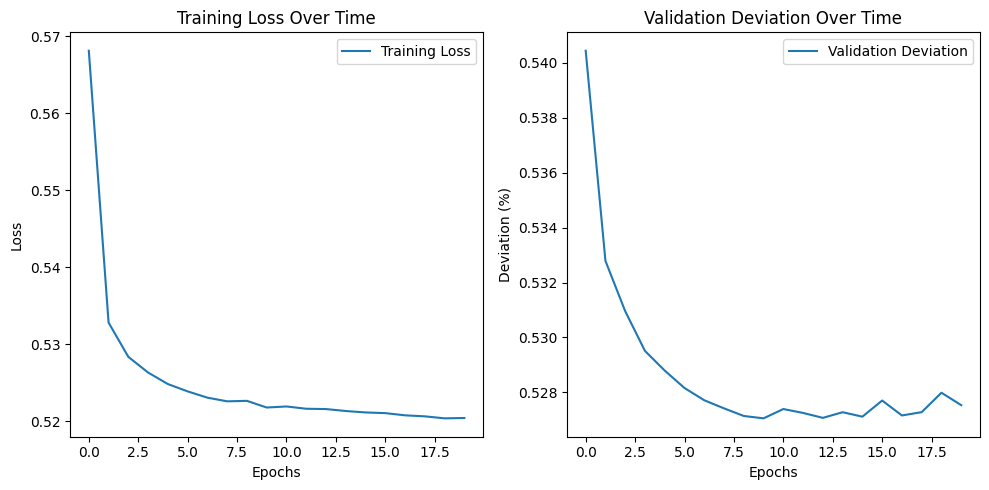

In [37]:

# Call your train(epochs, batch size, layers) function
train_losses, test_losses, model = train(20, 20, [169,4000,18211])

# Now plot the loss over epochs
plt.figure(figsize=(10, 5))

# Plotting the training loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()


# Plotting the deviation over epochs
plt.subplot(1, 2, 2)
plt.plot(test_losses, label='Validation Deviation')
plt.xlabel('Epochs')
plt.ylabel('Deviation (%)')
plt.title('Validation Deviation Over Time')
plt.legend()

plt.tight_layout()
plt.show()



In [38]:
def hot_encode(cell,compound):
    cell_vec = np.zeros(cell_mapping.size)
    cell_dict = {value: index for index, value in enumerate(cell_mapping)}

    compound_vec = np.zeros(compound_mapping.size)
    compound_dict = {value: index for index, value in enumerate(compound_mapping)}

    sm_names = df["sm_name"].tolist()
    functional_group_dict= dict(zip(sm_names, functional_groups_block))


    cell_vec[cell_dict[cell]]=1
    compound_vec[compound_dict[compound]]=1
    functional_group_vec = np.array(functional_group_dict[compound])
    vector = np.concatenate((cell_vec, compound_vec, functional_group_vec), axis = 0)
    tensor = torch.from_numpy(vector)
    return tensor


In [39]:
model(hot_encode("NK cells", "Clotrimazole"))

tensor([0.1363, 0.2250, 0.5096,  ..., 0.3857, 0.4271, 0.5658],
       dtype=torch.float64, grad_fn=<SigmoidBackward0>)

In [40]:
def get_expression(cell_type, compound_name):
    model.eval()
    tensor = model(hot_encode(cell_type,compound_name))
    np_array = tensor.detach().numpy()
    df = pd.DataFrame(np_array)
    return unnormalize(df[0],norm_min,norm_max)







In [27]:
# Read the sample submission and test set ID map
sample_submission = pd.read_csv("sample_submission.csv")
testDf = pd.read_csv("id_map.csv")

# Initialize an empty list to collect the predicted values
predicted_values = []

# Loop through the test set to get the predicted values
for idx, row in testDf.iterrows():
    cell_type = row['cell_type']
    sm_name = row['sm_name']
    
    # Call your get_expression method here
    expression_values = get_expression(cell_type, sm_name)
    
    # Append the values to the list
    predicted_values.append(expression_values)

# Convert the list of predicted values to a numpy array
predicted_values_array = np.array(predicted_values)

# Replace the values in the sample submission DataFrame
sample_submission.iloc[:, 1:] = predicted_values_array

# Save the DataFrame to a new CSV file
sample_submission.to_csv("my_submission.csv", index=False)

